# Citation

Samaneh Mahdavifar, Amgad Hanafy Salem, Princy Victor, Miguel Garzon, Amir H. Razavi, Natasha Hellberg, Arash Habibi Lashkari, “Lightweight Hybrid Detection of Data Exfiltration using DNS based on Machine Learning”, The 11th IEEE International Conference on Communication and Network Security (ICCNS), Dec. 3-5, 2021, Beijing Jiaotong University, Weihai, China.

In [1]:
import re
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Load heavy stateless DNS data

Load each csv file into a corresponding dataframe*

* Heavy stateless data has 3 benign csv files that will be concatenated into a single dataframe

In [2]:
stateful_heavy_audio = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateful_features-heavy_audio.pcap.csv")
stateful_heavy_audio['Category'] = "Audio"
stateful_heavy_compressed = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateful_features-heavy_compressed.pcap.csv")
stateful_heavy_compressed['Category'] = "Compressed"
stateful_heavy_exe = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateful_features-heavy_exe.pcap.csv")
stateful_heavy_exe['Category'] = "Exe"
stateful_heavy_image = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateful_features-heavy_image.pcap.csv")
stateful_heavy_image['Category'] = "Image"
stateful_heavy_text = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateful_features-heavy_text.pcap.csv")
stateful_heavy_text['Category'] = "Text"
stateful_heavy_video = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateful_features-heavy_video.pcap.csv")
stateful_heavy_video['Category'] = "Video"

stateful_heavy_benign = '../../../../datasets/CICBELLEXFDNS2021/Heavy/Benign/'

# Use regex to get stateful benign data only
stateful_heavy_benign_list = [f"{stateful_heavy_benign}{f}" for f in listdir(stateful_heavy_benign) if isfile(join(stateful_heavy_benign, f)) and re.search("^stateful", f) != None]

stateful_heavy_benign_df = pd.concat(map(pd.read_csv, stateful_heavy_benign_list), ignore_index=True)
stateful_heavy_benign_df['Category'] = "Benign"
stateful_heavy_benign_df['Class'] = "Benign"

In [3]:
stateful_heavy_malicious = pd.concat(
    [
        stateful_heavy_audio,
        stateful_heavy_compressed,
        stateful_heavy_exe,
        stateful_heavy_image,
        stateful_heavy_text,
        stateful_heavy_video,
    ],
    axis=0,
    ignore_index=True
)

stateful_heavy_malicious['Class'] = 'Malicious'

In [4]:
stateful_heavy_data = pd.concat(
    [
        stateful_heavy_malicious,
        stateful_heavy_benign_df
    ],
    axis=0,
    ignore_index=True
)

stateful_heavy_data = stateful_heavy_data.sample(frac=1).reset_index(drop=True)

In [5]:
stateful_heavy_data

,rr,A_frequency,NS_frequency,CNAME_frequency,SOA_frequency,NULL_frequency,PTR_frequency,HINFO_frequency,MX_frequency,TXT_frequency,...,unique_country,unique_asn,distinct_domains,reverse_dns,a_records,unique_ttl,ttl_mean,ttl_variance,Category,Class
0,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Text,Malicious
1,2.0,2,0,0,0,0,0,0,0,0,...,{'US'},{'AS13335'},{'172.64.92.126': {'frmovies.live'}},unknown,0,"[128, 122]",125.0,9.0,Benign,Benign
2,0.0,0,0,0,0,0,6,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1, 1, 1]",1.0,0.0,Compressed,Malicious
3,0.0,0,0,0,0,0,4,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1]",1.0,0.0,Compressed,Malicious
4,0.0,0,0,0,0,0,7,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1, 1, 1, 1]",1.0,0.0,Image,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141039,0.0,0,0,0,0,0,3,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1]",1.0,0.0,Text,Malicious
141040,0.0,0,0,0,0,0,3,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1]",1.0,0.0,Text,Malicious
141041,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Benign,Benign
141042,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Text,Malicious


# 2. Exploratory Data Analysis (EDA)

In [6]:
stateful_heavy_data.head()

,rr,A_frequency,NS_frequency,CNAME_frequency,SOA_frequency,NULL_frequency,PTR_frequency,HINFO_frequency,MX_frequency,TXT_frequency,...,unique_country,unique_asn,distinct_domains,reverse_dns,a_records,unique_ttl,ttl_mean,ttl_variance,Category,Class
0,0.0,0,0,0,0,0,2,0,0,0,...,set(),set(),{},unknown,0,"[1, 1]",1.0,0.0,Text,Malicious
1,2.0,2,0,0,0,0,0,0,0,0,...,{'US'},{'AS13335'},{'172.64.92.126': {'frmovies.live'}},unknown,0,"[128, 122]",125.0,9.0,Benign,Benign
2,0.0,0,0,0,0,0,6,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1, 1, 1]",1.0,0.0,Compressed,Malicious
3,0.0,0,0,0,0,0,4,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1]",1.0,0.0,Compressed,Malicious
4,0.0,0,0,0,0,0,7,0,0,0,...,set(),set(),{},unknown,0,"[1, 1, 1, 1, 1, 1, 1]",1.0,0.0,Image,Malicious


In [7]:
stateful_heavy_data.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'Category', 'Class'],
      dtype='object')

In [8]:
stateful_heavy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141044 entries, 0 to 141043
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rr                141044 non-null  float64
 1   A_frequency       141044 non-null  int64  
 2   NS_frequency      141044 non-null  int64  
 3   CNAME_frequency   141044 non-null  int64  
 4   SOA_frequency     141044 non-null  int64  
 5   NULL_frequency    141044 non-null  int64  
 6   PTR_frequency     141044 non-null  int64  
 7   HINFO_frequency   141044 non-null  int64  
 8   MX_frequency      141044 non-null  int64  
 9   TXT_frequency     141044 non-null  int64  
 10  AAAA_frequency    141044 non-null  int64  
 11  SRV_frequency     141044 non-null  int64  
 12  OPT_frequency     141044 non-null  int64  
 13  rr_type           141044 non-null  object 
 14  rr_count          141044 non-null  int64  
 15  rr_name_entropy   141044 non-null  float64
 16  rr_name_length    14

Show unique DNS exfiltration categories and their respective counts

In [9]:
stateful_heavy_data['Category'].value_counts()

Category
Benign        69016
Text          18916
Image         11076
Video         10897
Audio         10735
Compressed    10424
Exe            9980
Name: count, dtype: int64

Show unique DNS exfiltration classes and their respective counts

In [10]:
stateful_heavy_data['Class'].value_counts()

Class
Malicious    72028
Benign       69016
Name: count, dtype: int64

Check for NaN values

In [11]:
stateful_heavy_data.isna().any()

rr                  False
A_frequency         False
NS_frequency        False
CNAME_frequency     False
SOA_frequency       False
NULL_frequency      False
PTR_frequency       False
HINFO_frequency     False
MX_frequency        False
TXT_frequency       False
AAAA_frequency      False
SRV_frequency       False
OPT_frequency       False
rr_type             False
rr_count            False
rr_name_entropy     False
rr_name_length      False
distinct_ns         False
distinct_ip         False
unique_country      False
unique_asn          False
distinct_domains    False
reverse_dns         False
a_records           False
unique_ttl          False
ttl_mean            False
ttl_variance        False
Category            False
Class               False
dtype: bool

Show NaN value counts for each column

In [12]:
stateful_heavy_data.isna().sum()

rr                  0
A_frequency         0
NS_frequency        0
CNAME_frequency     0
SOA_frequency       0
NULL_frequency      0
PTR_frequency       0
HINFO_frequency     0
MX_frequency        0
TXT_frequency       0
AAAA_frequency      0
SRV_frequency       0
OPT_frequency       0
rr_type             0
rr_count            0
rr_name_entropy     0
rr_name_length      0
distinct_ns         0
distinct_ip         0
unique_country      0
unique_asn          0
distinct_domains    0
reverse_dns         0
a_records           0
unique_ttl          0
ttl_mean            0
ttl_variance        0
Category            0
Class               0
dtype: int64

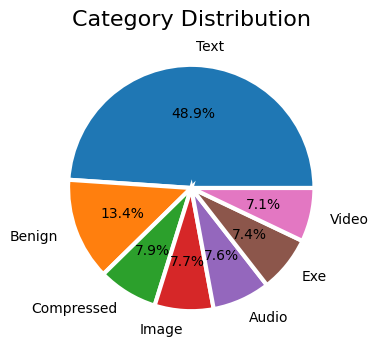

In [13]:
labels = stateful_heavy_data['Category'].unique()
values = stateful_heavy_data['Category'].value_counts()

plt.figure(figsize=(5,4))
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.title("Category Distribution", size=16)
plt.show()

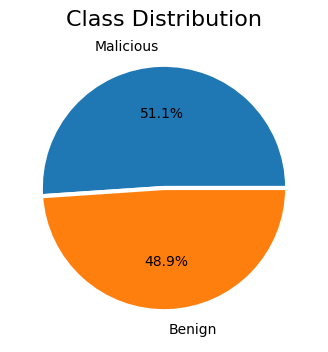

In [14]:
labels = stateful_heavy_data['Class'].unique()
values = stateful_heavy_data['Class'].value_counts()

plt.figure(figsize=(5,4))
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.title("Class Distribution", size=16)
plt.show()

# 3. Data preparation

1. Separate features from labels
2. Remove timestamps to prevent ML overfitting
3. Use target encoding for categorical columns
4. Encode labels
5. (Optional) Normalize data using [StandardScaler](https://www.geeksforgeeks.org/machine-learning/what-is-standardization-in-machine-learning/)

## 3.1. Separate features from labels

In [15]:
X_stateful_heavy_data = stateful_heavy_data.drop(['Class'], axis=1)
y_stateful_heavy_data = stateful_heavy_data['Class']

## 3.2. Remove timestamps to prevent ML overfiting

In [16]:
X_stateful_heavy_data.drop(['Category'], axis=1, inplace=True)

In [18]:
X_stateful_heavy_data.head()

,rr,A_frequency,NS_frequency,CNAME_frequency,SOA_frequency,NULL_frequency,PTR_frequency,HINFO_frequency,MX_frequency,TXT_frequency,...,distinct_ns,distinct_ip,unique_country,unique_asn,distinct_domains,reverse_dns,a_records,unique_ttl,ttl_mean,ttl_variance
0,0.0,0,0,0,0,0,2,0,0,0,...,0,set(),set(),set(),{},unknown,0,"[1, 1]",1.0,0.0
1,2.0,2,0,0,0,0,0,0,0,0,...,1,set(),{'US'},{'AS13335'},{'172.64.92.126': {'frmovies.live'}},unknown,0,"[128, 122]",125.0,9.0
2,0.0,0,0,0,0,0,6,0,0,0,...,0,set(),set(),set(),{},unknown,0,"[1, 1, 1, 1, 1, 1]",1.0,0.0
3,0.0,0,0,0,0,0,4,0,0,0,...,0,set(),set(),set(),{},unknown,0,"[1, 1, 1, 1]",1.0,0.0
4,0.0,0,0,0,0,0,7,0,0,0,...,0,set(),set(),set(),{},unknown,0,"[1, 1, 1, 1, 1, 1, 1]",1.0,0.0


## 3.3. Target encoding categorical columns

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder

Check unique value count in categorical columns in feature data

In [20]:
categorical_columns = X_stateful_heavy_data.select_dtypes(include='object').columns
for column in categorical_columns:
    print(f"Column: {column}, unique values: {len(X_stateful_heavy_data[column].unique())}")

Column: rr_type, unique values: 6
Column: distinct_ip, unique values: 1
Column: unique_country, unique values: 136
Column: unique_asn, unique values: 3317
Column: distinct_domains, unique values: 26910
Column: reverse_dns, unique values: 12337
Column: unique_ttl, unique values: 73


Target encode categorical columns

In [21]:
encoder = TargetEncoder(
    categories='auto',
    target_type='binary',  # Categorize between Benign and Malicious
    smooth='auto',
    cv=5,
    random_state=42
)

In [22]:
categorical_columns = X_stateful_heavy_data.select_dtypes(include='object').columns
categorical_columns

Index(['rr_type', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'unique_ttl'],
      dtype='object')

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_stateful_heavy_data, y_stateful_heavy_data, test_size=0.2, random_state=42)

In [24]:
%%time

X_train[categorical_columns] = encoder.fit_transform(X_train[categorical_columns], y_train)

CPU times: user 377 ms, sys: 11.2 ms, total: 388 ms
Wall time: 421 ms


In [25]:
%%time

X_test[categorical_columns] = encoder.transform(X_test[categorical_columns])

CPU times: user 116 ms, sys: 1.96 ms, total: 118 ms
Wall time: 118 ms


## 3.4. Encode labels

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [28]:
X_train.shape, y_train.shape

((112835, 27), (112835,))

In [29]:
X_test.shape, y_test.shape

((28209, 27), (28209,))

## 3.5. Normalize data

In [30]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 4. Model training

XGBoost will be trained and tested on heavy stateless data

## 4.1. Training

In [36]:
%%time

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

CPU times: user 2.29 s, sys: 4.5 ms, total: 2.3 s
Wall time: 311 ms


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## 4.2. Testing

In [37]:
%%time

y_pred = model.predict(X_test)

CPU times: user 180 ms, sys: 2 ms, total: 182 ms
Wall time: 28.7 ms


In [38]:
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [39]:
results_dict = {}

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGB_heavy_stateful"] = results

pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
XGB_heavy_stateful,0.851537,0.879273,0.848233,0.851537,0.148463,0.148463,0.385309


# 5. Hyperparameter tuning

Hyperparameter tuning using optuna

In [40]:
pass

# 6. Save model

In [41]:
import pickle

In [42]:
dir = '../../../../models/CICBELLEXFDNS2021/heavy/stateful/'

with open(f'{dir}XGB_heavy_stateful.pkl', 'wb') as f:
    pickle.dump(model, f)